In [1]:
!AzCopy /Source:https://ai4ehackathons.blob.core.windows.net/landcovertutorial /SourceSAS:"?se=2020-04-06T06%3A59%3A00Z&sp=rl&sv=2018-03-28&sr=c&sig=YD6mbqnmYTW%2Bs6guVndjQSQ8NUcV8F9HY%2BhPNWiulIo%3D" /Dest:D:\pixellevellandclassification /S
print('Done.')

[2020/01/25 01:36:38] Transfer summary:
-----------------
Total files transferred: 35
Transfer successfully:   35
Transfer skipped:        0
Transfer failed:         0
Elapsed time:            00.00:00:32
Done.


In [13]:
import subprocess

proc = subprocess.Popen('nvidia-smi', stdout=subprocess.PIPE)
print(proc.stdout.read().decode())

Sat Jan 25 02:24:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 425.25       Driver Version: 425.25       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M60           TCC  | 00000001:00:00.0 Off |                  Off |
| N/A   36C    P8    22W / 150W |      2MiB /  8129MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [14]:
import numpy as np
import pandas as pd
import os, argparse, cntk, tifffile, warnings, osr
from osgeo import gdal
from gdalconst import *
from mpl_toolkits.basemap import Basemap
from collections import namedtuple
from PIL import Image

In [15]:
model_filename = 'D:/pixellevellandclassification/models/trained.model'
model = cntk.load_model(model_filename)

naip_filename = 'D:/pixellevellandclassification/evaluation_data/C14_NAIP.tif'
lc_filename = naip_filename.replace('_NAIP.tif', '_LandCover.tif')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    naip_image = np.transpose(tifffile.imread(naip_filename))  / 255.0
    true_lc_image = np.transpose(tifffile.imread(lc_filename))
true_lc_image[true_lc_image > 4] = 4

In [16]:
def find_pixel_from_latlon(img_filename, lat, lon):
    ''' Find the indices for a point of interest '''
    img = gdal.Open(img_filename, GA_ReadOnly)
    img_proj = osr.SpatialReference()
    img_proj.ImportFromWkt(img.GetProjection())
    ulcrnrx, xstep, _, ulcrnry, _, ystep = img.GetGeoTransform()

    world_map = Basemap(lat_0=0,
                        lon_0=0,
                        llcrnrlat=-90, urcrnrlat=90,
                        llcrnrlon=-180, urcrnrlon=180,
                        resolution='c', projection='stere')
    world_proj = osr.SpatialReference()
    world_proj.ImportFromProj4(world_map.proj4string)
    ct_to_img = osr.CoordinateTransformation(world_proj, img_proj)

    xpos, ypos = world_map(lon, lat, inverse=False)
    xpos, ypos, _ = ct_to_img.TransformPoint(xpos, ypos)
    x = int((xpos - ulcrnrx) / xstep)
    y = int((ypos - ulcrnry) / ystep)

    return(x,y)

region_dim = 256
delta = int(region_dim / 2)
padding = 64

center_x, center_y = find_pixel_from_latlon(naip_filename, 37.055522, -78.638640)
true_lc_image = true_lc_image[center_x - delta:center_x + delta,
                              center_y - delta:center_y + delta].astype(np.float32)
naip_image = naip_image[:,
                        center_x - (delta + padding):center_x + delta + padding,
                        center_y - (delta + padding):center_y + delta + padding].astype(
                            np.float32)

In [17]:
n_rows = int(region_dim / 128)

# The model's predictions will have five values for each x-y position:
# these can be used to find the relative predicted probabilities of
# each of the five labels.
pred_lc_image = np.zeros((5, true_lc_image.shape[0], true_lc_image.shape[1]))

for row_idx in range(n_rows):
    for col_idx in range(n_rows):
        # Extract a 256 x 256 region from the NAIP image, to feed into the model.
        sq_naip = naip_image[:,
                             row_idx * 128:(row_idx * 128) + 256,
                             col_idx * 128:(col_idx * 128) + 256]
        
        # Get the model's prediction for the center of that region
        sq_pred_lc = np.squeeze(model.eval({model.arguments[0]: [sq_naip]}))
        
        # Save the predictions in the appropriate region of the result matrix
        pred_lc_image[:,
                      row_idx * 128:(row_idx * 128) + 128,
                      col_idx * 128:(col_idx * 128) + 128] = sq_pred_lc

c:\Anaconda\lib\site-packages\cntk\core.py:82: RuntimeWarning: data is not C contiguous; rearrange your data/computation to avoid costly data conversions
  RuntimeWarning)


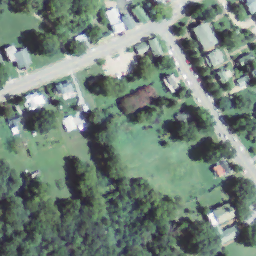

In [18]:
img_naip = Image.fromarray(np.transpose(
    naip_image * 255)[padding:-padding, padding:-padding, :3].astype(np.uint8))
img_naip

In [21]:
color_map = np.asarray([[0,0,0],
                        [0,0,1],
                        [0,0.5,0],
                        [0.5,1,0.5],
                        [0.5,0.375,0.375]], dtype=np.float32)

def visualize_label_image(input_image, hard=True):
    num_labels, height, width = input_image.shape
    label_image = np.zeros((3, height, width))
    if hard:
        my_label_indices = input_image.argmax(axis=0)
        for label_idx in range(num_labels):
            for rgb_idx in range(3):
                label_image[rgb_idx, :, :] += (my_label_indices == label_idx) *\
                    color_map[label_idx, rgb_idx]
    else:
        input_image = np.exp(input_image) / np.sum(np.exp(input_image), axis=0)
        for label_idx in range(num_labels):
            for rgb_idx in range(3):
                label_image[rgb_idx, :, :] += input_image[label_idx, :, :] * \
                    color_map[label_idx, rgb_idx]
    label_image = np.transpose(label_image * 255).astype(np.uint8)
    return(label_image)

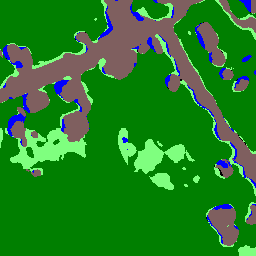

In [22]:
img_labels_pred = Image.fromarray(visualize_label_image(pred_lc_image, hard=True))
img_labels_pred